In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from mgen import rotation_around_axis
from mgen import rotation_from_angles
from mgen import rotation_around_x
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import RegularGridInterpolator

### create tore shape
n = 20

# angles values
theta = np.linspace(0, 2.*np.pi, n)
phi = np.linspace(0, 2.*np.pi, n)
theta, phi = np.meshgrid(theta, phi)

c = 8
tau = 50
a_values = np.linspace(0, 3, 100)
N = max([int(a+c) for a in a_values])
data = np.ones(shape = (2*N,2*N,2*N))
angles_values = np.linspace(1, 90, 1800) #list(range(9,11))

for angle in angles_values:
    matrix = rotation_around_axis([0, 0, 1], np.pi/2*(angle/180))
    for a in a_values:
        x = (c + a*np.cos(theta)) * np.cos(phi)
        y = (c + a*np.cos(theta)) * np.sin(phi)
        z = a * np.sin(theta)
        # flatten coordinates data
        x_data = np.ravel(x).T
        y_data = np.ravel(y).T
        z_data = np.ravel(z).T
        for i in range(0,n**2):
            xx = int(round(x_data[i]))
            yy = int(round(y_data[i]))
            zz = int(round(z_data[i]))
            data[xx-N, yy-N, zz-N] = int(999-tau*(a**2))
            m = matrix.dot([x_data[i],y_data[i],z_data[i]])
            mx = int(round(m[0]))
            my = int(round(m[1]))
            mz = int(round(m[2]))
            data[mx-N, my-N, mz-N] = int(999-tau*(a**2)) #rotated value
            
pos = np.where(data > 1)
fig = plt.figure()
ax = fig.add_subplot(221, projection='3d')
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.view_init(90,0)
ax1 = fig.add_subplot(222, projection='3d')
ax1.scatter(pos[0], pos[1], pos[2], c='black')
ax1.view_init(45,0)
ax2 = fig.add_subplot(223, projection='3d')
ax2.scatter(pos[0], pos[1], pos[2], c='black')
ax2.view_init(45,25)
plt.show()

In [ ]:
H = data[:,:,12]
min_i = min(np.ravel(H).T)
max_i = max(np.ravel(H).T)
for i in range(0,len(H)):
    for j in range(0,len(H)):
        if H[i][j] > 1:
            H[i][j] = int(255*(H[i][j]-min_i)/(max_i-min_i))
            
im = plt.imshow(H, cmap='gray', interpolation='none')
cbar = plt.colorbar(im)
plt.show()
#plt.imshow(H) #cmap=plt.cm.binary
#plt.show()

In [ ]:
H1 = data[10,:,:]
min_i1 = min(np.ravel(H1).T)
max_i1 = max(np.ravel(H1).T)
for i in range(0,len(H1)):
    for j in range(0,len(H1)):
        if H1[i][j] > 1:
            H1[i][j] = int(255*(H1[i][j]-min_i1)/(max_i1-min_i1))
            
im1 = plt.imshow(H1, cmap='gray', interpolation='none')
cbar = plt.colorbar(im1)
plt.show()

In [ ]:
np.save('data1.npy', data)
d = np.load('data1.npy')

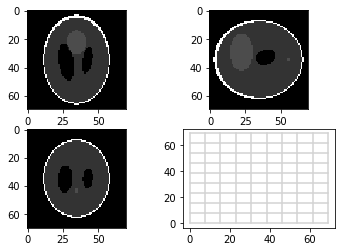

In [2]:
import numpy as np
import tomopy as tmpy
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline

N=70

### generating grid
def plot_grid(ax, gridx,gridy, **kwargs):
    for i in range(gridx.shape[0]):
        ax.plot(gridx[i,:], gridy[i,:], **kwargs)
    for i in range(gridx.shape[1]):
        ax.plot(gridx[:,i], gridy[:,i], **kwargs)

coordsX = np.linspace(0,N-1,10)
coordsY = np.linspace(0,N-1,10)
XX0, YY0 = np.meshgrid(coordsX, coordsY)

### Generating Ground Truth Image
data = tmpy.misc.phantom.shepp3d(size=N, dtype=u'float32')
H_transverse = data[32,:,:] #transverse view
H_sagittal = data[:,32,:]
H_coronal = data[:,:,32]
fig = plt.figure()
ax0 = fig.add_subplot(221)
ax1 = fig.add_subplot(222)
ax2 = fig.add_subplot(223)
ax3 = fig.add_subplot(224)
im_transverse = ax0.imshow(H_transverse, cmap='gray', interpolation='none')
im_coronal = ax1.imshow(H_coronal, cmap='gray', interpolation='none')
im_sagittal = ax2.imshow(H_sagittal, cmap='gray', interpolation='none')
plot_grid(ax3,XX0,YY0, color="lightgrey")
#cbar = plt.colorbar(im_transverse)
plt.show()

In [60]:
import SimpleITK as sitk


dimension = 2
spline_order = 1
direction_matrix_row_major = [1,0.0,0.0,1] 
origin = [0,0]  
domain_physical_dimensions = [N,N]
bspline = sitk.BSplineTransform(dimension, spline_order)
bspline.SetTransformDomainOrigin(origin)
bspline.SetTransformDomainDirection(direction_matrix_row_major)
bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
bspline.SetTransformDomainMeshSize((N,N))
# Random displacement of the control points.
len_params = len(bspline.GetParameters())
init = np.random.random(len_params)
new_list = random.sample(list(init), 10000)
params_init = []
for i in range(0,len_params):
    elem = init[i]
    if elem in new_list:
        params_init.append(elem)
    else:
        params_init.append(0)
params_init_2D = np.array(params_init_2D)
originalControlPointDisplacements = params_init_2D
bspline.SetParameters(originalControlPointDisplacements)

distXX_2D = np.zeros(shape=(10,10))
distYY_2D = np.zeros(shape=(10,10))

for i in range(0,10):
    for j in range(0,10):
        point = [XX0[i,j],YY0[i,j]]
        l = list(bspline.TransformPoint(point))
        distXX_2D[i,j], distYY_2D[i,j] = l[0], l[1] 

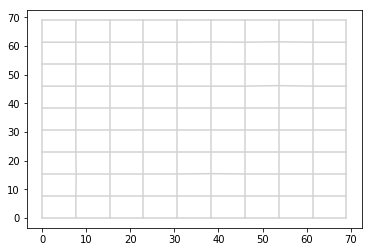

In [61]:
fig, ax = plt.subplots()
plot_grid(ax,distXX_2D,distYY_2D, color="lightgrey")
plt.show()

In [42]:
import scipy
import random
import SimpleITK as sitk
import scipy.interpolate as griddata


def b_spline(dat,params) : 
    dimension = 3
    spline_order = 1
    direction_matrix_row_major = [1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0] 
    origin = [0,0,0]  
    domain_physical_dimensions = [N,N,N]
    bspline = sitk.BSplineTransform(dimension, spline_order)
    bspline.SetTransformDomainOrigin(origin)
    bspline.SetTransformDomainDirection(direction_matrix_row_major)
    bspline.SetTransformDomainPhysicalDimensions(domain_physical_dimensions)
    bspline.SetTransformDomainMeshSize((N,N,N))
    # Random displacement of the control points.
    originalControlPointDisplacements = params
    bspline.SetParameters(originalControlPointDisplacements)
    coordsX = np.linspace(0,N-1,N)
    coordsY = np.linspace(0,N-1,N)
    coordsZ = np.linspace(0,N-1,N)
    XX, YY, ZZ = np.meshgrid(coordsX, coordsY, coordsZ)
    distXX = np.ones(shape=(N,N,N))
    distYY = np.ones(shape=(N,N,N))
    distZZ = np.ones(shape=(N,N,N))
    for i in range(0,N):
        for j in range(0,N):
            for k in range(0,N):
                point = [XX[i,j,k],YY[i,j,k],ZZ[i,j,k]]
                l = list(bspline.TransformPoint(point))
                distXX[i,j,k], distYY[i,j,k], distZZ[i,j,k] = l[0], l[1], l[2] 
    interp_vals = scipy.interpolate.griddata((np.ravel(distXX).T,np.ravel(distYY).T,np.ravel(distZZ).T), np.ravel(data).T, (XX,YY,ZZ), 'linear')
    interp_vals = np.nan_to_num(interp_vals)
    return interp_vals

In [48]:
len_params = 1073733
init = np.random.random(len_params)
new_list = random.sample(list(init), 9)
params_init = []
for i in range(0,len_params):
    elem = init[i]
    if elem in new_list:
        params_init.append(elem)
    else:
        params_init.append(0)
params_init = np.array(params_init)

9

In [ ]:
interp_vals = b_spline(data,params_init)

In [45]:
params_iter

array([0.75070955, 0.77519636, 0.14481911, ..., 0.0647699 , 0.5829979 ,
       0.93869492])

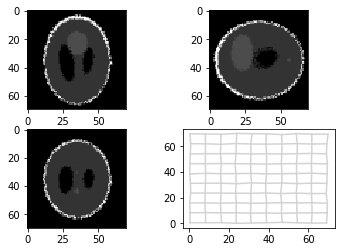

In [7]:
H_transverse_transformed = interp_vals[32,:,:] #transverse view
H_sagittal_transformed  = interp_vals[:,32,:]
H_coronal_transformed  = interp_vals[:,:,32]
fig1 = plt.figure()
ax01 = fig1.add_subplot(221)
ax11 = fig1.add_subplot(222)
ax21 = fig1.add_subplot(223)
ax31 = fig1.add_subplot(224)
im_transverse_transformed  = ax01.imshow(H_transverse_transformed , cmap='gray', interpolation='none')
im_coronal_transformed  = ax11.imshow(H_coronal_transformed , cmap='gray', interpolation='none')
im_sagittal_transformed  = ax21.imshow(H_sagittal_transformed , cmap='gray', interpolation='none')
plot_grid(ax31,distXX_2D,distYY_2D, color="lightgrey")
#cbar = plt.colorbar(im_transverse_transformed)
plt.show()

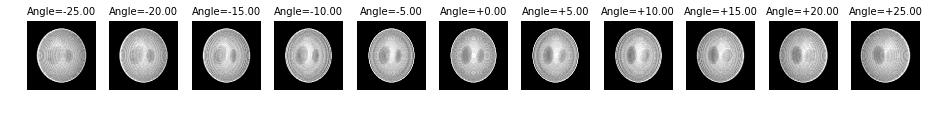

In [9]:
# projections
nang = 11
angles_proj = tmpy.sim.project.angles(nang, ang1=-25.0, ang2=25.0)
center = 0.5*np.array(data.shape)
p1 = tmpy.sim.project.project(data, angles_proj, center=center, pad=False)
plt.figure(figsize=(16,4))
for i in range(11):
    plt.subplot(2, 11, i+1)
    plt.imshow(p1[i,:,:], cmap='gray')
    plt.title("Angle={:+.2f}".format(-25 + i*(50/10)), fontsize=10)
    plt.axis('off')
plt.show()

In [10]:
def rotation_matrix(angle, axis='x'):
    if axis=='x':
        rot = np.array([[1, 0, 0],
                        [0, np.cos(angle), -np.sin(angle)],
                        [0, np.sin(angle), np.cos(angle)]])
    elif axis=='y':
        rot = np.array([[np.cos(angle), 0, -np.sin(angle)],
                        [0, 1, 0],
                        [np.sin(angle), 0, np.cos(angle)]])
    else:
        rot = np.array([[np.cos(angle), -np.sin(angle), 0],
                        [np.sin(angle), np.cos(angle), 0],
                        [0, 0, 1]])
    return rot


def affine_transformation(f, angle, translation, axis='x', order=3):
    
    # Rotation matrix
    rot = rotation_matrix(angle, axis)
        
    # Compute rotation center (center of volume)
    center = 0.5*np.array(f.shape)
    offset=-(center-center.dot(rot)).dot(np.linalg.inv(rot))

    # Compute transformation (along with interpolation)
    out = scipy.ndimage.affine_transform(f,rot, offset=offset)
    # Binarize output
    #out[out>0.90] = 1.0
    #out[out<=0.90] = 0.0
    
    out = scipy.ndimage.affine_transform(out, np.eye(3), offset=translation, order=order)
    
    return(out)

In [11]:
def backward_projection(p):
    n, d = p.shape[0], p.shape[1]
    back = np.zeros((d, d, d))
    # Rotation center
    center = 0.5*np.array(back.shape)
    for i in range(n):
        # Compute expanded projection
        proj = np.expand_dims(p[i], axis=2)
        expanded_proj = np.tile(proj, d)
        # Compute associated rotation
        angle = -25 + i*(50/10)
        angle = (angle/360)*2*np.pi
        rot = rotation_matrix(angle, axis='x')
        offset=-(center-center.dot(rot)).dot(np.linalg.inv(rot))
        expanded_proj = scipy.ndimage.affine_transform(expanded_proj, rot, offset=offset)
        back += (1/n) * expanded_proj
    return back

In [12]:
def rescale_array(f):
    min_f, max_f = np.min(f), np.max(f)
    return (f - min_f)/(max_f - min_f)

In [13]:
def recon_grad_descent(p, stepsize=1e-2, tol=1e-2, max_iter=100,
                       angles=tmpy.sim.project.angles(11, ang1=-25.0, ang2=25.0),
                       init=None):
    # Parameters
    n, d = p.shape[0], p.shape[1]
    # Initialization
    if init is not None:
        f = init
    else:
        f = np.zeros((N,N,N))
    it = 0
    cost = []
    # Repeat until convergence
    while it<max_iter:
        proj = tmpy.sim.project.project(f, angles, center=0.5*np.array(f.shape), pad=False)
        criterion = np.linalg.norm( proj - p )
        cost.append(criterion)
        if criterion<tol:
            break
        else:
            f = f - stepsize * backward_projection( proj - p )
            it += 1
    
    return rescale_array(f), cost

In [14]:
f1_rec, cost1 = recon_grad_descent(p1, stepsize=1e-3, tol=1e-2, max_iter=20)

In [15]:
f1_rec = rescale_array(f1_rec)

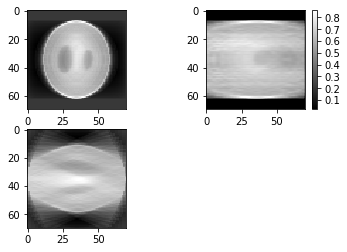

In [63]:
H_transverse_rec = f1_rec[32,:,:] #transverse view
H_sagittal_rec = f1_rec[:,32,:]
H_coronal_rec = f1_rec[:,:,32]
fig = plt.figure()
ax0_rec = fig.add_subplot(223)
ax1_rec = fig.add_subplot(221)
ax2_rec = fig.add_subplot(222)
im_transverse_rec = ax0_rec.imshow(H_transverse_rec, cmap='gray', interpolation='none')
im_coronal_rec = ax1_rec.imshow(H_coronal_rec, cmap='gray', interpolation='none')
im_sagittal_rec = ax2_rec.imshow(H_sagittal_rec, cmap='gray', interpolation='none')
cbar = plt.colorbar(im_transverse_rec)
plt.show()

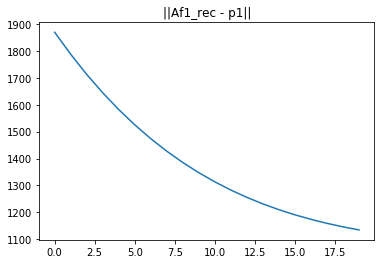

In [17]:
plt.plot(cost1)
plt.title('||Af1_rec - p1||')
plt.show()

In [18]:
p2 = tmpy.sim.project.project(interp_vals, angles_proj, center=center, pad=False)
f2_rec, cost2 = recon_grad_descent(p2, stepsize=1e-3, tol=1e-2, max_iter=20)

In [19]:
f2_rec = rescale_array(f2_rec)

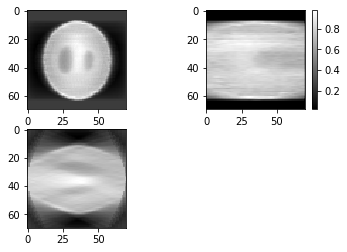

In [62]:
H_transverse_rec = f2_rec[32,:,:] #transverse view
H_sagittal_rec = f2_rec[:,32,:]
H_coronal_rec = f2_rec[:,:,32]
fig = plt.figure()
ax0_rec = fig.add_subplot(223)
ax1_rec = fig.add_subplot(221)
ax2_rec = fig.add_subplot(222)
im_transverse_rec = ax0_rec.imshow(H_transverse_rec, cmap='gray', interpolation='none')
im_coronal_rec = ax1_rec.imshow(H_coronal_rec, cmap='gray', interpolation='none')
im_sagittal_rec = ax2_rec.imshow(H_sagittal_rec, cmap='gray', interpolation='none')
cbar = plt.colorbar(im_transverse_rec)
plt.show()

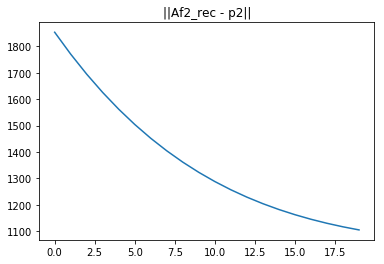

In [21]:
plt.plot(cost2)
plt.title('||Af2_rec - p2||')
plt.show()

In [26]:
def cost_registration(f1, f2, params):
    return 0.5*np.linalg.norm(f2 - b_spline(f1,params))**2

len_params = 3*(71**3)
eps = 1e-3
epsilon = np.array([eps]*len_params)
def transformation_gradient(f1, f2, params, epsilon):
    # Params
    dcost_angle = (cost_registration(f1, f2, params+epsilon) - cost_registration(f1, f2, params-epsilon))/(2*np.linalg.norm(epsilon)**2)

    return dcost_angle

In [27]:
def registration_grad_descent(f1, f2, stepsize=1e-4, tol=1e-3, max_iter=7, init_params=None):
    # Initialization
    if init_params is not None:
        params = init_params
    else:
        np.random.seed(5)
        params = np.random.random(len_params)
    it = 0
    cost = []
    # Repeat until convergence
    while it<max_iter:
        criterion = cost_registration(rescale_array(f1), rescale_array(f2), params)
        cost.append(criterion)       
        if criterion<tol:
            break
        else:
            grad = transformation_gradient(rescale_array(f1), rescale_array(f2), params, epsilon)
            params = params - stepsize * params
            it += 1
    
    return params, cost

In [28]:
def iterative_recon_reg(p1, p2, k=3, stepsize_recon=1e-3, iter_recon=3, stepsize_reg=1e-6):
    # Initialization
    n, d = p1.shape[0], p1.shape[1]
    f1, f2 = np.zeros((N,N,N)), np.zeros((N,N,N))
    init_params = np.random.random(len_params)
    
    for i in range(k):
        # j steps of reconstruction (j = iter_recon)
        f1, _ = recon_grad_descent(p1, stepsize=stepsize_recon, max_iter=iter_recon,init=f1)
        f1 = rescale_array(f1)
        f2, _ = recon_grad_descent(p2, stepsize=stepsize_recon, max_iter=iter_recon,init=f2)
        f2 = rescale_array(f2)
        # registration step
        params, _ = registration_grad_descent(f1_rec, f2_rec, max_iter=5, stepsize=5e-6,
                                                          init_params=init_params)
        # change f2 for its registered version
        f2 = b_spline(f1,params)
        f2 = rescale_array(f2)
        
    return f1, f2, params

In [29]:
f1_rec_iter, f2_rec_iter, params_iter = iterative_recon_reg(p1, p2,
                                                                             k=4, stepsize_recon=1e-4,
                                                                             iter_recon=4, stepsize_reg=1e-4)

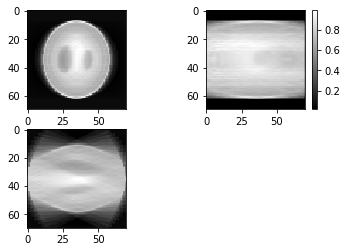

In [30]:
H_transverse_rec_iter1 = f1_rec_iter[32,:,:] #transverse view
H_sagittal_rec_iter1 = f1_rec_iter[:,32,:]
H_coronal_rec_iter1 = f1_rec_iter[:,:,32]
fig = plt.figure()
ax0_rec_iter1 = fig.add_subplot(223)
ax1_rec_iter1 = fig.add_subplot(221)
ax2_rec_iter1 = fig.add_subplot(222)
im_transverse_rec_iter1 = ax0_rec_iter1.imshow(H_transverse_rec_iter1, cmap='gray', interpolation='none')
im_coronal_rec_iter1 = ax1_rec_iter1.imshow(H_coronal_rec_iter1, cmap='gray', interpolation='none')
im_sagittal_rec_iter1 = ax2_rec_iter1.imshow(H_sagittal_rec_iter1, cmap='gray', interpolation='none')
cbar = plt.colorbar(im_transverse_rec_iter1)
plt.show()

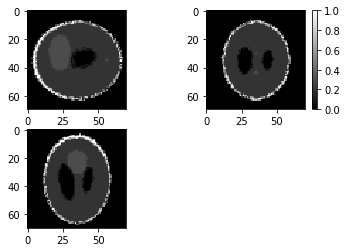

In [31]:
H_transverse_rec_iter2 = f2_rec_iter[32,:,:] #transverse view
H_sagittal_rec_iter2 = f2_rec_iter[:,32,:]
H_coronal_rec_iter2 = f2_rec_iter[:,:,32]
fig = plt.figure()
ax0_rec_iter2 = fig.add_subplot(223)
ax1_rec_iter2 = fig.add_subplot(221)
ax2_rec_iter2 = fig.add_subplot(222)
im_transverse_rec_iter2 = ax0_rec_iter2.imshow(H_transverse_rec_iter2, cmap='gray', interpolation='none')
im_coronal_rec_iter2 = ax1_rec_iter2.imshow(H_coronal_rec_iter2, cmap='gray', interpolation='none')
im_sagittal_rec_iter2 = ax2_rec_iter2.imshow(H_sagittal_rec_iter2, cmap='gray', interpolation='none')
cbar = plt.colorbar(im_transverse_rec_iter2)
plt.show()

In [64]:
def plot_volume(f, d=71):
    plt.figure(figsize=(12,4))
    plt.subplot("131")
    plt.title("Coronal view")
    plt.imshow(f[:,d//2,:], cmap='gray')
    plt.subplot("132")
    plt.title("Transverse view")
    plt.imshow(f[d//2,:,:], cmap='gray')
    plt.subplot("133")
    plt.title("Sagittal view")
    plt.imshow(f[:,:,d//2], cmap='gray')
    plt.show()

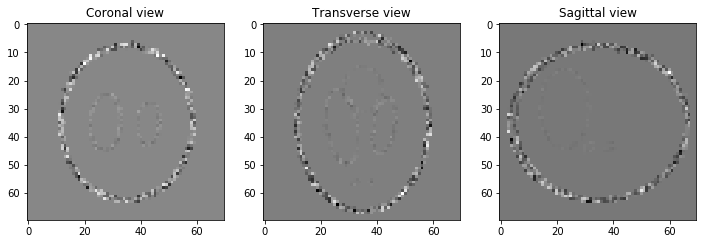

In [65]:
plot_volume(interp_vals - f2_rec_iter)

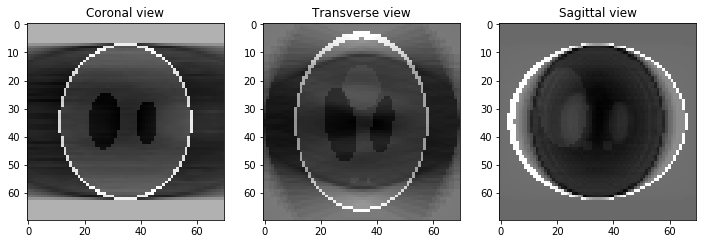

In [66]:
plot_volume(data - f1_rec_iter)

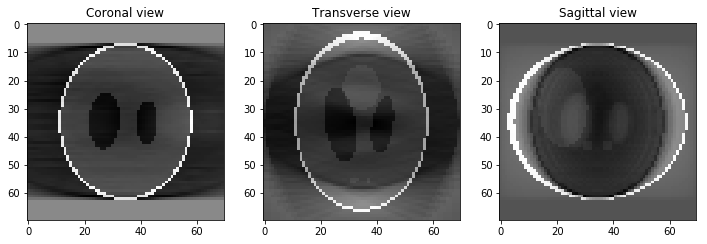

In [67]:
plot_volume(data - f1_rec)

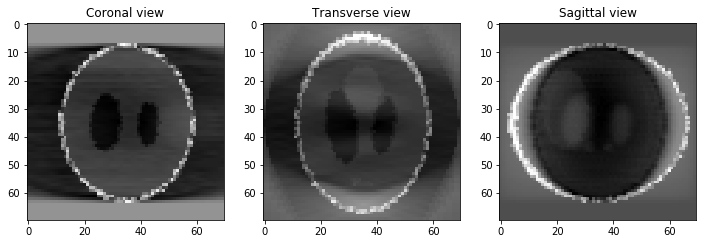

In [69]:
plot_volume(interp_vals - f2_rec)